In [ ]:
# !rm -rf /content/*

# Get data from kaggle

In [ ]:
from google.colab import files
import os
files.upload()  # kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bglemser","key":"1b0d7921dada59101501451e17cb9c72"}'}

In [ ]:
!pip install -q kaggle

os.makedirs("/root/.kaggle", exist_ok=True)
if os.path.exists("kaggle.json"):
    os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
# 2. Download dataset
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# 3. Unzip dataset
if not os.path.exists("datasciencebowl"):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# 4. Unzip train / test folders
if not os.path.exists("datasciencebowl/train"):
    !unzip -q datasciencebowl/train.zip -d datasciencebowl/train

if not os.path.exists("datasciencebowl/test"):
    !unzip -q datasciencebowl/test.zip -d datasciencebowl/test

!unzip -q datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# 5. Fix folder structure
if os.path.exists("datasciencebowl/train/train"):
    !mv datasciencebowl/train/train/* datasciencebowl/train/
    !rmdir datasciencebowl/train/train

if os.path.exists("datasciencebowl/test/test"):
    !mv datasciencebowl/test/test/* datasciencebowl/test/
    !rmdir datasciencebowl/test/test

/bin/bash: line 1: /usr/bin/mv: Argument list too long
rmdir: failed to remove 'datasciencebowl/test/test': Directory not empty


In [ ]:
# Checking
DATA_DIR = "/content/datasciencebowl"
print("Train classes:", len(os.listdir(f"{DATA_DIR}/train")))
print("Test :",  len(os.listdir(f"{DATA_DIR}/test")))

Train classes: 121
Test : 1


#create simple dataset

create a dataset, that has only 60 classes. Removing all classes with less than 114 images.
- resize the images to 64x64
- z- standardised data

In [ ]:
dataset_path = "/content/datasciencebowl/train"

class_counts = {
    cls: len(os.listdir(os.path.join(dataset_path, cls)))
    for cls in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, cls))
}

# only classes with more than 114 images (half of the classes)
valid_classes = [cls for cls, count in class_counts.items() if count > 114]

print(f"Verbleibende Klassen: {len(valid_classes)}")
print("Erste 10 Klassen:", valid_classes[:10])

Verbleibende Klassen: 60
Erste 10 Klassen: ['hydromedusae_aglaura', 'siphonophore_calycophoran_sphaeronectes', 'radiolarian_colony', 'trichodesmium_puff', 'artifacts_edge', 'hydromedusae_shapeB', 'acantharia_protist', 'euphausiids', 'echinoderm_larva_seastar_brachiolaria', 'trichodesmium_bowtie']


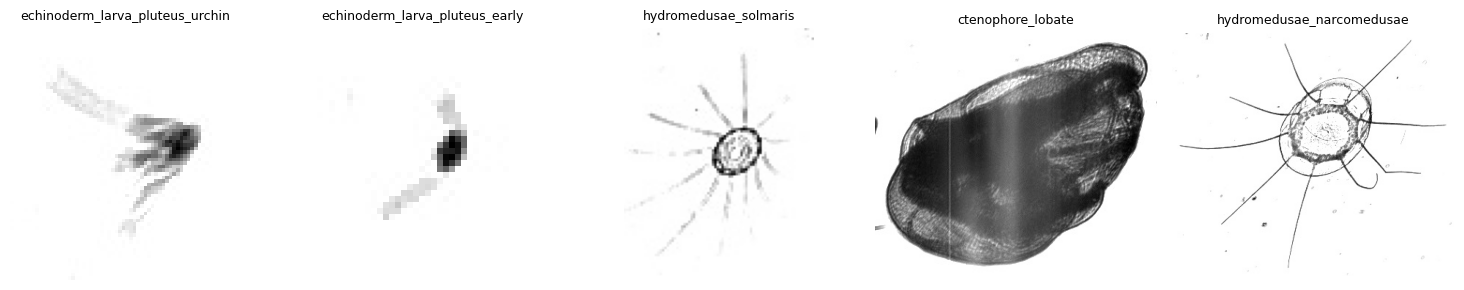

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/content/datasciencebowl/train"

# Alle Klassenordner holen
classes = [d for d in os.listdir(dataset_path)
           if os.path.isdir(os.path.join(dataset_path, d))]

# 5 zufällige Klassen auswählen
selected_classes = random.sample(classes, 5)

plt.figure(figsize=(15, 3))

for i, cls in enumerate(selected_classes):
    class_dir = os.path.join(dataset_path, cls)

    # Zufälliges Bild aus dieser Klasse
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)

    # Bild laden (Graustufen erzwingen)
    img = Image.open(img_path).convert("L")

    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(cls, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
#reseizing the images to 64x64
import os
from PIL import Image

#create a new directory for the resized images
src_root = "/content/datasciencebowl/train"
dst_root = "/content/datasciencebowl/train_64x64"

IMG_SIZE = (64, 64)

os.makedirs(dst_root, exist_ok=True)


In [ ]:
import os
import shutil

dst_root = "/content/datasciencebowl/train_64x64"

for item in os.listdir(dst_root):
    item_path = os.path.join(dst_root, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)
    else:
        os.remove(item_path)


In [ ]:
#resize images from selected classes
for class_name in valid_classes:
    src_class_dir = os.path.join(src_root, class_name)
    dst_class_dir = os.path.join(dst_root, class_name)

    if not os.path.isdir(src_class_dir):
        continue

    os.makedirs(dst_class_dir, exist_ok=True)

    for img_name in os.listdir(src_class_dir):
        src_img_path = os.path.join(src_class_dir, img_name)
        dst_img_path = os.path.join(dst_class_dir, img_name)

        try:
            with Image.open(src_img_path) as img:
                img = img.convert("RGB")        # wichtig für Konsistenz
                img = img.resize(IMG_SIZE, Image.BILINEAR)
                img.save(dst_img_path)
        except Exception as e:
            print(f"Fehler bei {src_img_path}: {e}")


In [ ]:
print("Anzahl Klassen:", len(os.listdir(dst_root)))
for cls in os.listdir(dst_root)[:3]:
    print(cls, "→", len(os.listdir(os.path.join(dst_root, cls))), "Bilder")


Anzahl Klassen: 60
detritus_filamentous → 394 Bilder
unknown_unclassified → 425 Bilder
siphonophore_calycophoran_sphaeronectes → 179 Bilder


In [ ]:
#calculate the values important for normalisation
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

RESIZED_DIR = "/content/datasciencebowl/train_64x64"

pixel_sum = 0.0
pixel_sq_sum = 0.0
pixel_count = 0

for cls in tqdm(os.listdir(RESIZED_DIR)):
    cls_dir = os.path.join(RESIZED_DIR, cls)

    if not os.path.isdir(cls_dir):
        continue

    for f in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, f)

        try:
            img = np.array(
                Image.open(img_path).convert("L"),  # greyscale images
                dtype=np.float32
            )

            pixel_sum += img.sum()
            pixel_sq_sum += (img ** 2).sum()
            pixel_count += img.size  # H × W

        except Exception as e:
            print(f"Fehler bei {img_path}: {e}")

global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean**2)

print("Global Mean:", global_mean)
print("Global Std :", global_std)

100%|██████████| 60/60 [00:06<00:00,  8.70it/s]

Global Mean: 240.31981
Global Std : 40.326065


In [ ]:
#save normalised images to a new directory
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

SRC_DIR = "/content/datasciencebowl/train_64x64"
DST_DIR = "/content/datasciencebowl/train_64x64_z"

os.makedirs(DST_DIR, exist_ok=True)

for cls in tqdm(os.listdir(SRC_DIR)):
    src_cls_dir = os.path.join(SRC_DIR, cls)
    dst_cls_dir = os.path.join(DST_DIR, cls)

    if not os.path.isdir(src_cls_dir):
        continue

    os.makedirs(dst_cls_dir, exist_ok=True)

    for f in os.listdir(src_cls_dir):
        src_img_path = os.path.join(src_cls_dir, f)

        try:
            img = np.array(
                Image.open(src_img_path).convert("L"),
                dtype=np.float32
            )

            # z-Normalisierung
            img_z = (img - global_mean) / global_std

            # Dateiname beibehalten, aber .npy
            base_name = os.path.splitext(f)[0]
            dst_path = os.path.join(dst_cls_dir, base_name + ".npy")

            np.save(dst_path, img_z)

        except Exception as e:
            print(f"Fehler bei {src_img_path}: {e}")


100%|██████████| 60/60 [00:10<00:00,  5.81it/s]


# Prepare the data for MobileNetV2


In [ ]:
#split the data in train and validation data (80/20)
from sklearn.model_selection import train_test_split

DATA_DIR = "/content/datasciencebowl/train_64x64_z"

# Listen für X und y
X, y = [], []

classes = sorted(os.listdir(DATA_DIR))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    for f in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, f)
        img = np.load(img_path)  # .npy Datei
        X.append(img)
        y.append(class_to_idx[cls])

X = np.array(X)  # Shape: (num_samples, 64,64)
y = np.array(y)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape  :", X_val.shape)


Train shape: (21783, 64, 64)
Val shape  : (5446, 64, 64)


In [ ]:
#the model expects RGB images so we need to dublicate one channel
# X_train: (N,H,W) → (N,H,W,3)
X_train_rgb = np.stack([X_train]*3, axis=-1)
X_val_rgb   = np.stack([X_val]*3, axis=-1)

print("Train RGB shape:", X_train_rgb.shape)


Train RGB shape: (21783, 64, 64, 3)


In [ ]:
#extra scaling

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

X_train_pre = preprocess_input(X_train_rgb)  # skaliert automatisch auf [-1,1]
X_val_pre   = preprocess_input(X_val_rgb)


In [ ]:
y_train_cat = y_train  # SparseCategoricalCrossentropy
y_val_cat   = y_val


In [ ]:
#add data agumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,          # ±20 degree rotation
    width_shift_range=0.1,      # horizontal movement
    height_shift_range=0.1,     # vertikal movement
    zoom_range=0.1,             # zoom in and out
    horizontal_flip=True,       # horizontal mirroring
    vertical_flip=True,         # vertikal mirroring
    brightness_range=[0.9,1.1] #add small changes in brightness
)


In [ ]:
train_generator = train_datagen.flow(
    X_train_pre,
    y_train_cat,
    batch_size=32
)

## MobileNetV2

In [ ]:
#add callback function for F1 macro
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf

class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.macro_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        macro_f1 = f1_score(self.y_val, y_pred, average="macro")
        self.macro_f1s.append(macro_f1)

        print(f"\nEpoch {epoch+1}: val_macro_f1 = {macro_f1:.4f}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

num_classes = 60
input_shape = (64, 64, 3)

# 1️⃣ MobileNetV2 Backbone without classification head
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# 2️⃣ freeze base
base_model.trainable = False

# 3️⃣ add head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)           # Base frozen
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# 4️⃣ compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5️⃣ oly train head
history_head = model.fit(
    train_generator,
    validation_data=(X_val_pre, y_val_cat),
    epochs=5
)


/tmp/ipython-input-1277183304.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


681/681 ━━━━━━━━━━━━━━━━━━━━ 81s 95ms/step - accuracy: 0.1990 - loss: 3.3978 - val_accuracy: 0.3599 - val_loss: 2.3757
Epoch 2/5
681/681 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.3231 - loss: 2.5651 - val_accuracy: 0.4025 - val_loss: 2.1181
Epoch 3/5
681/681 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.3494 - loss: 2.3691 - val_accuracy: 0.4104 - val_loss: 2.0501
Epoch 4/5
681/681 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.3643 - loss: 2.2840 - val_accuracy: 0.4271 - val_loss: 1.9871
Epoch 5/5
681/681 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.3829 - loss: 2.2278 - val_accuracy: 0.4273 - val_loss: 1.9179


In [ ]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

macro_f1_cb = MacroF1Callback(X_val_pre, y_val_cat)

history_finetune = model.fit(train_generator,
                             validation_data=(X_val_pre, y_val_cat),
                             epochs=20,
                              callbacks=[macro_f1_cb])


Epoch 1/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2633 - loss: 2.9590
Epoch 1: val_macro_f1 = 0.0328
681/681 ━━━━━━━━━━━━━━━━━━━━ 78s 93ms/step - accuracy: 0.2634 - loss: 2.9585 - val_accuracy: 0.0786 - val_loss: 6.1927
Epoch 2/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3787 - loss: 2.2722
Epoch 2: val_macro_f1 = 0.0797
681/681 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.3787 - loss: 2.2722 - val_accuracy: 0.1276 - val_loss: 4.7621
Epoch 3/20
680/681 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3995 - loss: 2.1617
Epoch 3: val_macro_f1 = 0.1727
681/681 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.3995 - loss: 2.1617 - val_accuracy: 0.3017 - val_loss: 2.7117
Epoch 4/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4145 - loss: 2.0817
Epoch 4: val_macro_f1 = 0.2251
681/681 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.4145 - loss: 2.0817 - val_accuracy: 0.3665 - val_loss: 2.3150
Epoch 5/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

In [ ]:
#print losses ans accuracy
train_losses = history_finetune.history['loss']
val_losses = history_finetune.history['val_loss']
val_accuracies = history_finetune.history['val_accuracy']


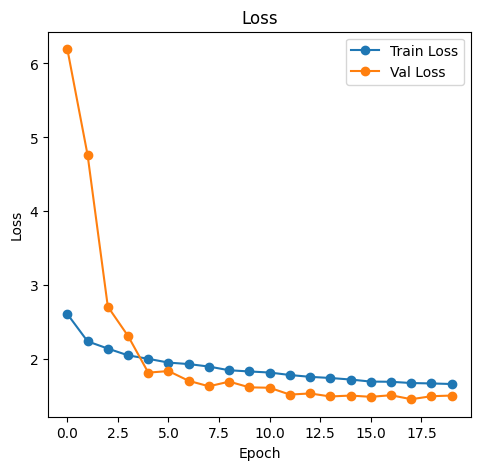

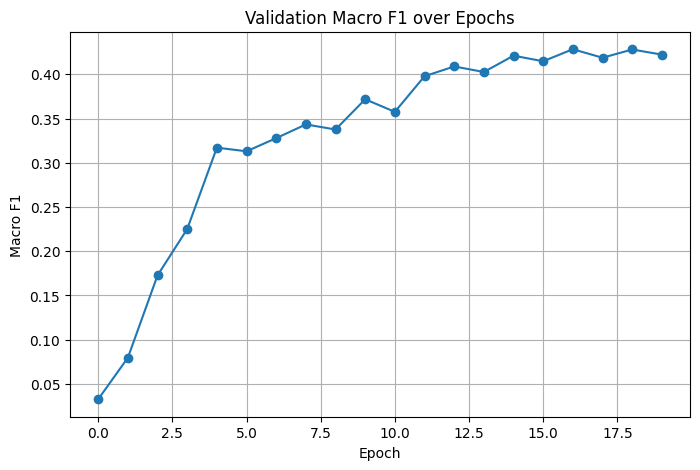

In [ ]:
# Visualizations

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

# Training and Validation Loss
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='o', label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#plot macroF1 score over epochs
plt.figure(figsize=(8,5))
plt.plot(macro_f1_cb.macro_f1s, marker='o')
plt.title("Validation Macro F1 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.grid(True)
plt.show()

# Validation Accuracy
#plt.subplot(1,2,2)
#plt.plot(val_accuracies, marker='o', color='green')
#plt.title("Validation Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")

plt.show()

In [ ]:
#compute macro F1 score
# X_val_pre = your preprocessed validation images
# y_val_cat = true labels (integers from 0 to num_classes-1)

import numpy as np

# Get predicted probabilities from the model
y_pred_probs = model.predict(X_val_pre, batch_size=32)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
from sklearn.metrics import f1_score

# Macro F1 treats all classes equally
macro_f1 = f1_score(y_val_cat, y_pred, average='macro')

print(f"Macro F1 score: {macro_f1:.4f}")


Macro F1 score: 0.4222


In [ ]:
#result per classes
per_class_f1 = f1_score(y_val_cat, y_pred, average=None)

for i, f1 in enumerate(per_class_f1):
    print(f"Class {i}: F1 = {f1:.4f}")
